# Storytelling for [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)
---

Instructions for this exercise:

> Get going by asking the following questions and looking for the answers with some code and plots:
>
> * Can you count something interesting?
> 
> * Can you find some trends (high, low, increase, decrease, anomalies)?
> 
> * Can you make a bar plot or a histogram?
> 
> * Can you compare two related quantities?
> 
> * Can you make a scatterplot?
> 
> * Can you make a time-series plot?
> 
> Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?
> 
> By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

---

In [1]:
# load all datasets, then merge and clean them to be used:
import lib.clean_db as clean_db

df = clean_db.load_from('data') # 'data': directory that contains .csv files
#display(df.head(3))

A Jupyter Widget

In [2]:
# must import remaining modules after clean_db.load_from() to be able to visualize the progress bar
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

## 1. Where are the restaurants?
Even though not every restaurant in the database have geographic coordinates associated with them, it's still interesting to see where in the world these observations were recorded.

In [3]:
# debug: cut down the size of the DataFrame
#df = df.head(5)

# keep the only unique pairs of latitude/longitude: i.e. one geographical reference per location
unique_coords_df = df.drop_duplicates(subset=['latitude', 'longitude'], keep='first', inplace=False)
print('>>> There are', unique_coords_df.shape[0], 'different geographic locations.')
#display(unique_coords_df)

# setup Folium close to Japan
japan_map = folium.Map(location=[37.6, 139.5], zoom_start=5, tiles="Stamen Terrain")

for _, row in unique_coords_df.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], popup=row['area_name'], radius=4, color='#000000', weight=0.6, opacity=1.0, fill=True, fill_color='#ff5733', fill_opacity=1.0).add_to(japan_map)

display(japan_map)

>>> There are 238 different geographic locations.


## 2. Which are the most visited areas?
It's clear from the previous map that most (if it not all) of the data comes from japanese restaurants. So which of these are the most visited locations?

In [4]:
# debug: cut down the size of the DataFrame
# df = df.head(10)

start_date = df['visit_date'].min()
end_date = df['visit_date'].max()
print('>>> Analysing data from', start_date, 'to', end_date)

# create DataFrame to store the result of the groupby()
#visitors_df = df.groupby(['latitude', 'longitude'])['visitors'].agg('sum')
visitors_df = pd.DataFrame({'total_visitors' : df.groupby(["latitude", "longitude"])['visitors'].agg('sum')}).reset_index()

# sort rows by the amount of visitors
visitors_df.sort_values('total_visitors', ascending=False, inplace=True)
#display(visitors_df.head(3))

# discard rows with lat/lon == -1
visitors_df = visitors_df[visitors_df['latitude'] >= 0]  
#display(visitors_df.head(3))

max_value = visitors_df['total_visitors'].iloc[0]
print('>>> Largest historical concentration of visitors in a single venue:', max_value)

# setup Folium close to Japan
japan_map = folium.Map(location=[37.6, 139.5], zoom_start=5, tiles="Stamen Terrain")

for _, row in visitors_df.iterrows():
    circle_sz = row['total_visitors'] / max_value * 50
    popup_msg = 'From ' + start_date + ' to ' + end_date + '<br>' + str(str(row['total_visitors']) + ' visits')
    folium.CircleMarker(location=[row['latitude'], row['longitude']], popup=popup_msg, radius=circle_sz, color='#000000', weight=0.6, opacity=1.0, fill=True, fill_color='#ffd800', fill_opacity=0.8).add_to(japan_map)

display(japan_map)

>>> Analysing data from 2016-01-01 to 2017-05-31
>>> Largest historical concentration of visitors in a single venue: 414113


## 3. Is there more activity during weekends and holidays?
One might be forgiven to think that restaurants receives more visitation during weekends and holidays. The following plot shows that this is not a rule. We should probably check every restaurant individually later.

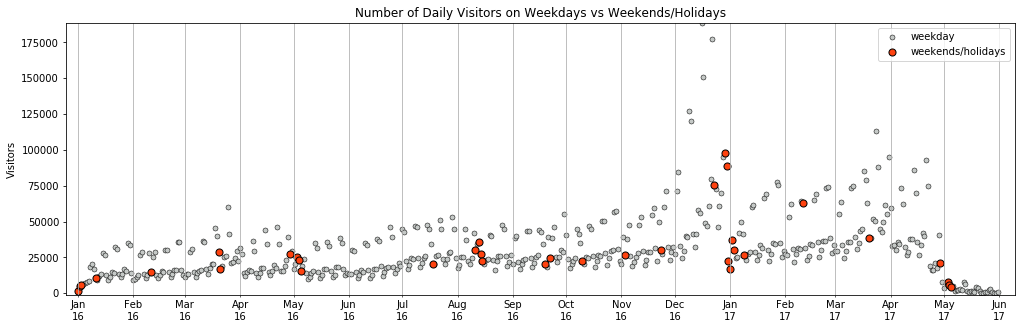

In [5]:
import matplotlib.dates as mdates
#df = df.tail(1000)
# is jan 03 really holiday?
#display(df[df.visit_date == '2016-01-03'].head())

daily_df = df
daily_df = daily_df.set_index('visit_date')
daily_df.index = pd.to_datetime(daily_df.index)

daily_df = daily_df.resample('D').sum()
# display(daily_df.head(5))

# drop unecessary columns
daily_df = daily_df.drop(['latitude', 'longitude'], axis=1)

# update holiday values >= 1 to just 1
daily_df.loc[daily_df['holiday_flg'] > 0, 'holiday_flg'] = 1
#display(daily_df.head(5))

####
# plot the number of visits per day, coloring by weekday and weekends/holidays
###
fig, ax = plt.subplots(figsize=(17,5))
for klass, row in daily_df.groupby('holiday_flg'):
    c = 'weekday'
    class_color = 'xkcd:silver'
    marker_sz = 25
    linew = 0.5
    if (klass == 1): 
        c = 'weekends/holidays'
        class_color = 'xkcd:orangered'
        marker_sz = 50
        linew = 1
    ax.scatter(row.index, row.visitors, label=c, s=marker_sz, color=class_color, lw=linew, edgecolors='black')
    
ax.legend()
#ax.set_facecolor('xkcd:gray') # background color
ax.set_title('Number of Daily Visitors on Weekdays vs Weekends/Holidays')
#ax.set_xlabel('Dates')
ax.set_ylabel('Visitors')
ax.margins(0, 0) # set margins to avoid "whitespace" while showing the first x-tick
ax.xaxis.grid(True, which="minor")

# set monthly xticks: major ticks are hidden and minor ticks display month/year information:
months = plt.matplotlib.dates.MonthLocator()
plt.gca().xaxis.set_minor_locator(months)
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%y'))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))
plt.gca().xaxis.set_major_locator(plt.NullLocator())

plt.show()

## 4. What are the most popular genres of restaurants?

Text(0.5,0,'Visitors')

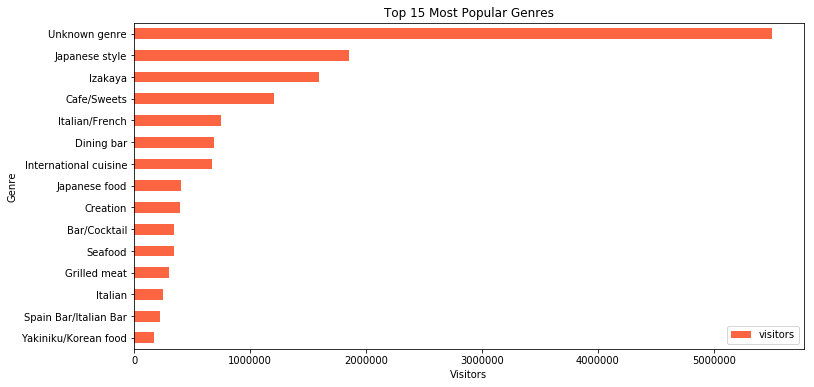

In [6]:
# as_index=False converts the result of a groupby() to a DataFrame object
popular_genre_df = df.groupby('genre_name', as_index=False).visitors.sum()

# replace empty cell value for 'Unknown'
popular_genre_df.loc[popular_genre_df['genre_name'] == '', 'genre_name'] = 'Unknown genre'

# sort by visitors
popular_genre_df.sort_values('visitors', inplace=True, ascending=True)

#reset index to genre strings
popular_genre_df = popular_genre_df.set_index('genre_name')
# display(popular_genre_df.head(10))

ax = popular_genre_df.tail(15).plot(kind='barh', figsize=(12,6), title='Top 15 Most Popular Genres', color='#fb6542')
ax.set_ylabel("Genre")
ax.set_xlabel("Visitors")

## 5. Which restaurants have the most visitors?

Text(0.5,0,'Visitors')

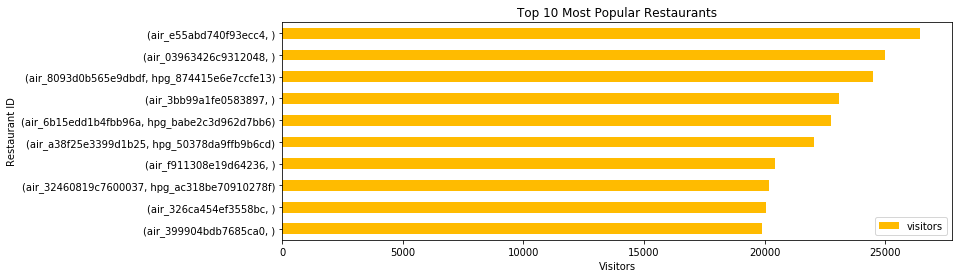

In [7]:
# as_index=False converts the result of a groupby() to a DataFrame object
popular_restaurants_df = df.groupby(['air_store_id','hpg_store_id'], as_index=False).visitors.sum()

# sort by visitors
popular_restaurants_df.sort_values('visitors', inplace=True, ascending=True)

#reset index to genre strings
popular_restaurants_df = popular_restaurants_df.set_index(['air_store_id','hpg_store_id'])
#display(popular_restaurants_df.tail(3))

ax = popular_restaurants_df.tail(10).plot(kind='barh', figsize=(12,4), title='Top 10 Most Popular Restaurants', color='#ffbb00')
ax.set_ylabel("Restaurant ID")
ax.set_xlabel("Visitors")

In [8]:
###
# Plot their location on the map
###
#df = df.set_index(['air_store_id','hpg_store_id'])

# popular_restaurants_df = popular_restaurants_df.tail(10)

# df = df.reset_index()
# popular_restaurants_df = popular_restaurants_df.reset_index()

# display(df.head(5))
# display(popular_restaurants_df.head(5))

## 6. Other ideas:

- Plot how many restaurants are active every month;

- Plot new restaurants being added along the following months;

- Anomalies on the system: why did the visition VS reserve increased gradually?